In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as ss

% matplotlib inline

In [3]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

In [4]:
def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii &   (cos_theta_k_out>np.abs(np.cos(theta_max)))
    return data[ii]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary * vrot
    v_y = x_unitary * vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']/v_th
    new_data['x_frec'] += atom_velocities['y']*data['k_y']/v_th
    new_data['x_frec'] += atom_velocities['z']*data['k_z']/v_th
    
    return new_data

In [5]:
def plot_spectra(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2,label='label'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    a = plt.hist(-data_theta['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color='black',
                 linewidth=lw, bins=50, alpha=alpha, label=label)

In [6]:
mint= np.pi/2.0 -0.05
maxt = np.pi/2.0

data_A = read_data(vout=5, vrot=0, logtau=5)
data_B = read_data(vout=5, vrot=100, logtau=5)
data_A = filter_by_theta(data_A, mint, maxt)
data_B = filter_by_theta(data_B, mint, maxt)

n_vrot = 10
all_vrot = np.linspace(0.0, 200.0, n_vrot)
data_C = {}
for i in range(n_vrot):
    data_C[i] = doppler_shift(data_A, vrot=all_vrot[i])
    data_C[i] = filter_by_theta(data_C[i], mint, maxt)

In [7]:
line_mean = np.ones(n_vrot)
line_width = np.ones(n_vrot)
line_skewness = np.ones(n_vrot)
for i in range(n_vrot):
    line_mean[i] = np.mean(data_C[i]['x_frec'])
    line_width[i] = np.std(data_C[i]['x_frec'])
    line_skewness[i] = ss.skew(data_C[i]['x_frec'])

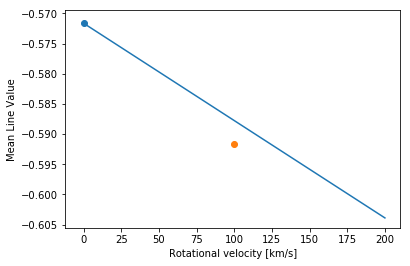

In [8]:
plt.plot(all_vrot, line_mean)
plt.scatter(0, np.mean(data_A['x_frec']))
plt.scatter(100, np.mean(data_B['x_frec']))
plt.xlabel('Rotational velocity [km/s]')
plt.ylabel('Mean Line Value')

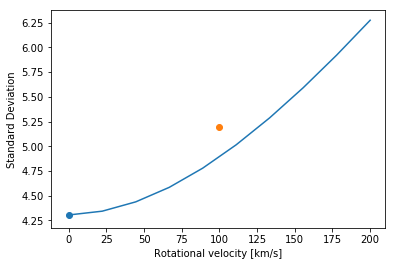

In [9]:
plt.plot(all_vrot, line_width)
plt.scatter(0, np.std(data_A['x_frec']))
plt.scatter(100, np.std(data_B['x_frec']))
plt.xlabel('Rotational velocity [km/s]')
plt.ylabel('Standard Deviation')

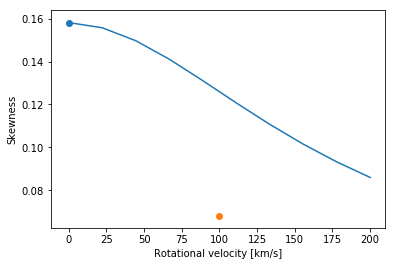

In [10]:
plt.plot(all_vrot, line_skewness)
plt.scatter(0, ss.skew(data_A['x_frec']))
plt.scatter(100, ss.skew(data_B['x_frec']))
plt.xlabel('Rotational velocity [km/s]')
plt.ylabel('Skewness')